In [20]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
path = 'data'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


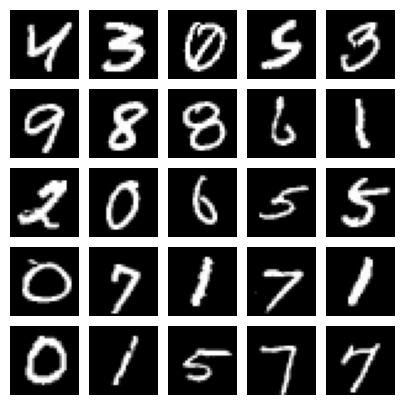

In [24]:
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 30
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2, num_classes=10):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.num_classes = num_classes  # Number of digit classes (0-9)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )

        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)

        # Modify decoder input: latent_dim + num_classes (for one-hot label)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(device)
        z = mean + std * epsilon
        return z

    def decode(self, z, labels):
        # Convert label to one-hot encoding and concatenate with latent vector
        one_hot_labels = F.one_hot(labels, num_classes=self.num_classes).float().to(device)
        z = torch.cat([z, one_hot_labels], dim=1)
        return self.decoder(z)

    def forward(self, x, labels):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z, labels)
        return x_hat, mean, logvar

# Initialize the model
model = VAE().to(device)



In [88]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
# Loss function (Reconstruction + KL Divergence)
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KL_divergence

# Training function
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, labels) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)  # Flatten image
            x = (x + 1) / 2  # Rescale to [0, 1]
            labels = labels.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x, labels)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {overall_loss / len(train_loader.dataset):.4f}")
    
    return overall_loss

# Train the model
train(model, optimizer, epochs=epochs, device=device)



Epoch 1/50, Average Loss: 180.1533
Epoch 2/50, Average Loss: 151.3332
Epoch 3/50, Average Loss: 146.3698
Epoch 4/50, Average Loss: 143.5384
Epoch 5/50, Average Loss: 141.5402
Epoch 6/50, Average Loss: 140.1292
Epoch 7/50, Average Loss: 139.0861
Epoch 8/50, Average Loss: 138.2866
Epoch 9/50, Average Loss: 137.5882
Epoch 10/50, Average Loss: 136.9973
Epoch 11/50, Average Loss: 136.5515
Epoch 12/50, Average Loss: 136.0911
Epoch 13/50, Average Loss: 135.7044
Epoch 14/50, Average Loss: 135.4261
Epoch 15/50, Average Loss: 135.0478
Epoch 16/50, Average Loss: 134.7920
Epoch 17/50, Average Loss: 134.5971
Epoch 18/50, Average Loss: 134.3473
Epoch 19/50, Average Loss: 134.1582
Epoch 20/50, Average Loss: 133.9972
Epoch 21/50, Average Loss: 133.8143
Epoch 22/50, Average Loss: 133.6216
Epoch 23/50, Average Loss: 133.5157
Epoch 24/50, Average Loss: 133.3386
Epoch 25/50, Average Loss: 133.2612
Epoch 26/50, Average Loss: 133.0839
Epoch 27/50, Average Loss: 132.9702
Epoch 28/50, Average Loss: 132.8767
E

7880445.8671875

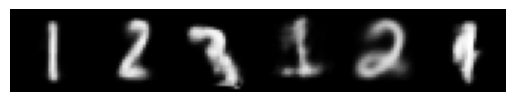

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sequence(model, sequence, latent_dim=2):
    """
    Generates a sequence of digits based on a given numeric input.
    
    Args:
    - model: Trained VAE model
    - sequence: Integer or string representing the sequence of digits (e.g., 3132)
    - latent_dim: Size of the latent vector

    Returns:
    - A concatenated image of generated digits
    """
    model.eval()  # Set model to evaluation mode
    images = []  # Store generated digit images

    with torch.no_grad():
        for digit in str(sequence):  # Process each digit separately
            label = int(digit)  # Convert character to integer (0-9)
            z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
            label_tensor = torch.tensor([label], dtype=torch.long).to(device)  # Convert label to tensor
            generated_image = model.decode(z, label_tensor).view(28, 28).cpu().numpy()  # Generate image
            images.append(generated_image)

    # Concatenate all images horizontally
    sequence_image = np.hstack(images)

    return sequence_image

# Example usage
label_sequence = 123124  # Generate sequence of digits
generated_sequence_img = generate_sequence(model, label_sequence)

plt.imshow(generated_sequence_img, cmap="gray")
plt.axis("off")
plt.show()


